# To be continued or discontinued: investigating secret formula for successful movie franchise
This notebook contains in-depth analysis and visualization for our project. Some figures in the blog post is taken from this notebook.

## Data loading and preprocessing

__Delete unused import before submission__

In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce
# #For interactive plots 

# import plotly.graph_objects as go #pip install plotly
# import dash
# from dash import dcc, html #pip install dash
# from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate, get_movie, get_genre_counts, clean_character_metadata, custom_autopct
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#loading the inflation rate data set from the columbia bank 
inflation_rate_df=get_inflation_rate()
#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')
#Data frame with all the movies with preprocessing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')
#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

#Data frame of only the franchise name and their characteristics
# franchise_data_df = get_franchise_data(franchise_df)

# Drop franchises where any movie in the franchise does not have a release date
# franchise_df_2 = franchise_df.groupby('collection_id').filter(lambda x: x['Movie release date'].notna().all())
# print("Number of movies with all movies having release dates : ", len(franchise_df_2))
# print(franchise_df)

## Data presentation 

## Diversity and franchise movies

In this part, we will particularly tackle Q2-3 of our research questions. That is:

> 2-3: Do actors of certain ethnicity/gender groups appear more or less commonly in franchise movies? Are they depicted positively (hero/heroine) or negatively (villain) in the movie?

Let's start by looking at the actor gender distribution of franchise and non-franchise movies.
We'll load the data and drop rows if any of the columns in `col_for_dropna` is missing. This will make the following analysis easier without dropping too many rows (55467/395202 dropped).

In [12]:
# Dataloading for this part
col_names = [
    'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 
    'Actor_date_of_birth', 'Actor_gender', 'Actor_height_m', 'Actor_ethnicity_Freebase_ID', 
    'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 
    'Freebase_character_ID', 'Freebase_actor_ID'
]

col_for_dropna = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date',
                  'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID',
                  'Freebase_actor_ID']

# plot_df = pd.read_csv('../data/plot_summaries.txt', sep='\t', header=None, names=['Wikipedia_movie_ID', 'summary_plot'])
character_df = pd.read_csv('data/character.metadata.tsv', names=col_names, sep='\t')
character_df = clean_character_metadata(character_df, mapping_path='data/ethnicity_mapping.csv', columns=col_for_dropna)
# create a new column to check if the movie is part of a franchise
character_df["is_in_franchise"] = character_df["Wikipedia_movie_ID"].isin(franchise_df["Wikipedia movie ID"])

Dropping rows with missing values in any of ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID', 'Freebase_actor_ID'].
Number of rows dropped: 55467
395202 rows remaining.


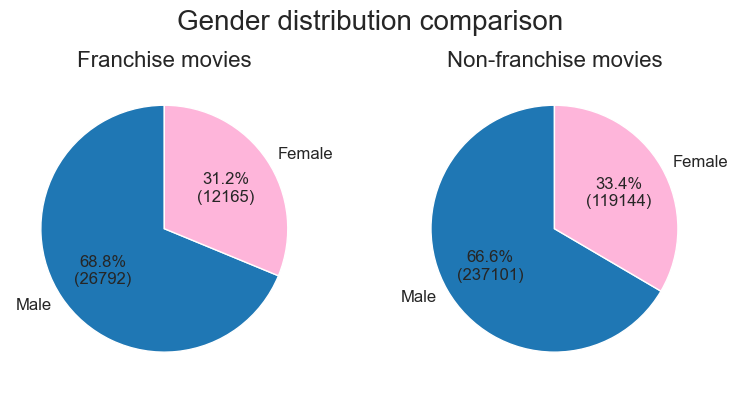

In [35]:
# Calculate the proportion of each gender for character_df
gender_proportion_non_fr = character_df[~character_df['is_in_franchise']]['Actor_gender'].value_counts()
# Calculate the proportion of each gender for fr_character_df
gender_proportion_franchise = character_df[character_df["is_in_franchise"]]['Actor_gender'].value_counts()
# Plot the gender proportions as pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Plot for fr_character_df
gender_proportion_franchise.plot(kind='pie', ax=axes[0], autopct=custom_autopct(gender_proportion_franchise),
                                 startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'],
                                 fontsize=12)
axes[0].set_ylabel('')
axes[0].set_title('Franchise movies', fontsize=16)

# Plot for character_df
gender_proportion_non_fr.plot(kind='pie', ax=axes[1], autopct=custom_autopct(gender_proportion_non_fr),
                           startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'], fontsize=12)
axes[1].set_ylabel('')
axes[1].set_title('Non-franchise movies', fontsize=16)
# Set overarching title
fig.suptitle('Gender distribution comparison', fontsize=20)
plt.tight_layout()
plt.show()

It seems that actor gender distribution remains the same for franchise and non-franchise movies. This is unsurprising as most of us can agree that there are particulalry many female characters in franchise movies than non-franchise movies, at least anecdotally.

Next, we shift our focus to ethnicity groups. Contrary to actor gender information, actor ethnicity is not available for the majority of actors. Upon observing the dataset, we hypothesized that the actors with known ethnicity are those with more publicity and therefore, more likely to play main roles in the movies. The ethnicity distribution of these main actors can be representative of which racial group is more or less featured in the movie. Bearing this in mind, we will proceed to visualize actors' racial group distribution for franchise and non-franchise movies.

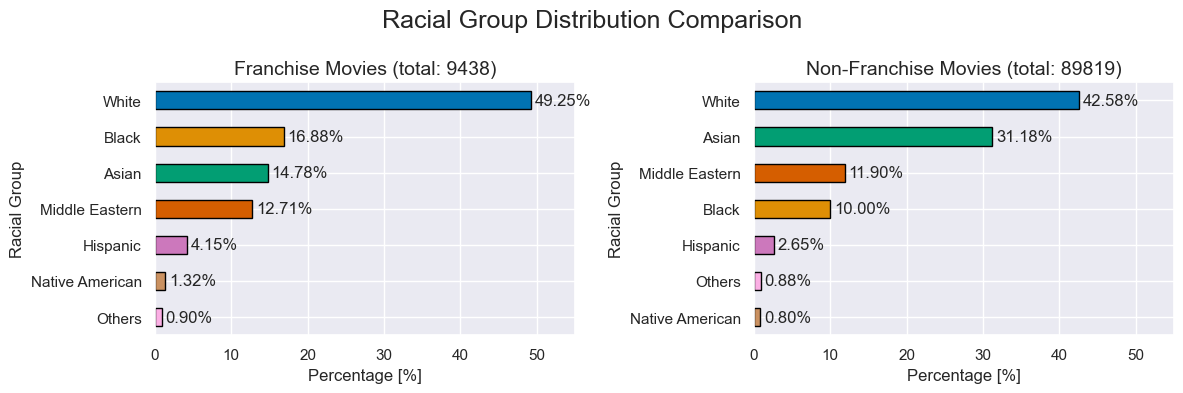

In [45]:
# Define colors for racial groups
colors = dict(zip(['White', 'Black', 'Asian', 'Middle Eastern', 'Hispanic', 'Native American', 'Others'], sns.color_palette("colorblind", 7)))

# Calculate the percentage of each racial group for franchise and non-franchise movies
racial_proportion_franchise = character_df[character_df["is_in_franchise"]].value_counts("racial_group")
racial_proportion_non_franchise = character_df[~character_df['is_in_franchise']].value_counts("racial_group")
percentage_fr = (racial_proportion_franchise / racial_proportion_franchise.sum()) * 100
percentage_non_fr = (racial_proportion_non_franchise / racial_proportion_non_franchise.sum()) * 100
fr_count = racial_proportion_franchise.sum()
non_fr_count = racial_proportion_non_franchise.sum()

# Plot the racial percentages as horizontal bar charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for franchise movies
bars_fr = percentage_fr.plot(kind='barh', ax=axes[0], color=[colors[group] for group in percentage_fr.index], edgecolor='black')
axes[0].set_title(f'Franchise Movies (total: {fr_count})', fontsize=14)
axes[0].set_xlabel('Percentage [%]')
axes[0].set_ylabel('Racial Group')
axes[0].invert_yaxis()  # Inverse y-axis
axes[0].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_fr.patches:
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

# Plot for non-franchise movies
bars_non_fr = percentage_non_fr.plot(kind='barh', ax=axes[1], color=[colors[group] for group in percentage_non_fr.index], edgecolor='black')
axes[1].set_title(f'Non-Franchise Movies (total: {non_fr_count})', fontsize=14)
axes[1].set_xlabel('Percentage [%]')
axes[1].set_ylabel('Racial Group')
axes[1].invert_yaxis()  # Inverse y-axis
axes[1].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_non_fr.patches:
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center', fontsize=12)

# Set overarching title
fig.suptitle('Racial Group Distribution Comparison', fontsize=18)

plt.tight_layout()
plt.show()

The percentages in each plot sum up to 100%. Notice that compared to non-franchise movies, 

What about ethnicity? Are there any differences in the distribution?

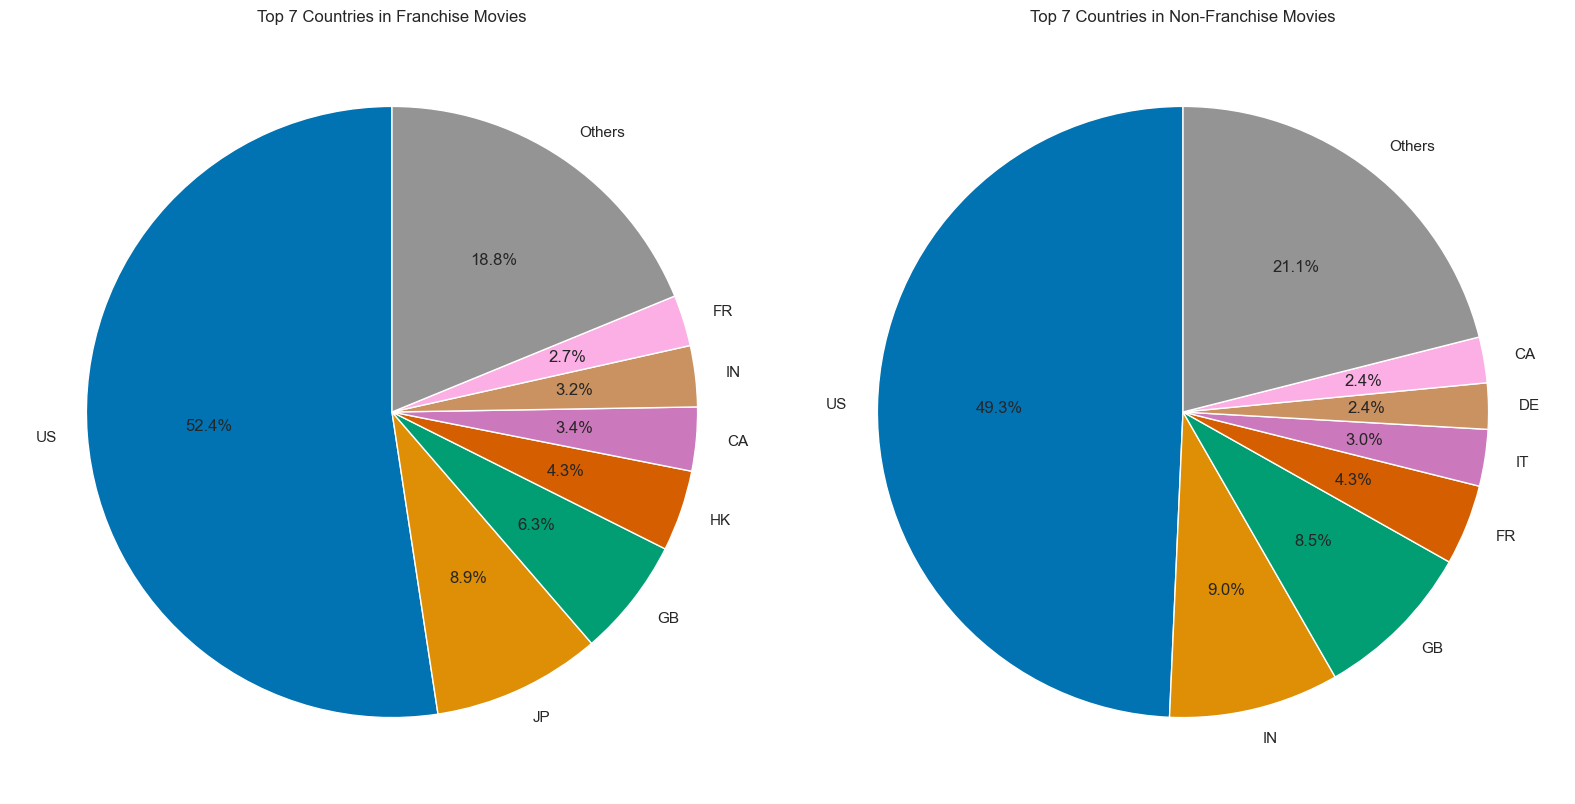

In [ ]:
# Process the list of countries for franchise movies
list_of_countries = movies_df[movies_df['collection_id'].notna()]['tmdb_origin_country'].fillna('')
for i in range(len(list_of_countries)):
    list_of_countries.iloc[i] = list_of_countries.iloc[i].strip("[]").replace("'", "").split(", ")

# Flatten the list of countries and count occurrences
country_counts = list_of_countries.explode().value_counts().drop("")

# Group the counts of countries outside the top 7 into 'Others'
top_countries = country_counts.nlargest(7)
other_countries_count = country_counts.iloc[7:].sum()
top_countries['Others'] = other_countries_count

# Process the list of countries for non-franchise movies
list_of_countries_non_fr = movies_no_franchise_df.tmdb_origin_country.fillna('')
for i in range(len(list_of_countries_non_fr)):
    list_of_countries_non_fr.iloc[i] = list_of_countries_non_fr.iloc[i].strip("[]").replace("'", "").split(", ")

# Flatten the list of countries and count occurrences
country_counts_non_fr = list_of_countries_non_fr.explode().value_counts().drop("")

# Group the counts of countries outside the top 7 into 'Others'
top_countries_non_fr = country_counts_non_fr.nlargest(7)
other_countries_count_non_fr = country_counts_non_fr.iloc[7:].sum()
top_countries_non_fr['Others'] = other_countries_count_non_fr

# Plot the pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for franchise movies
top_countries.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("colorblind", len(top_countries)))
axes[0].set_ylabel('')
axes[0].set_title('Top 7 Countries in Franchise Movies')

# Plot for non-franchise movies
top_countries_non_fr.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("colorblind", len(top_countries_non_fr)))
axes[1].set_ylabel('')
axes[1].set_title('Top 7 Countries in Non-Franchise Movies')

plt.tight_layout()
plt.show()

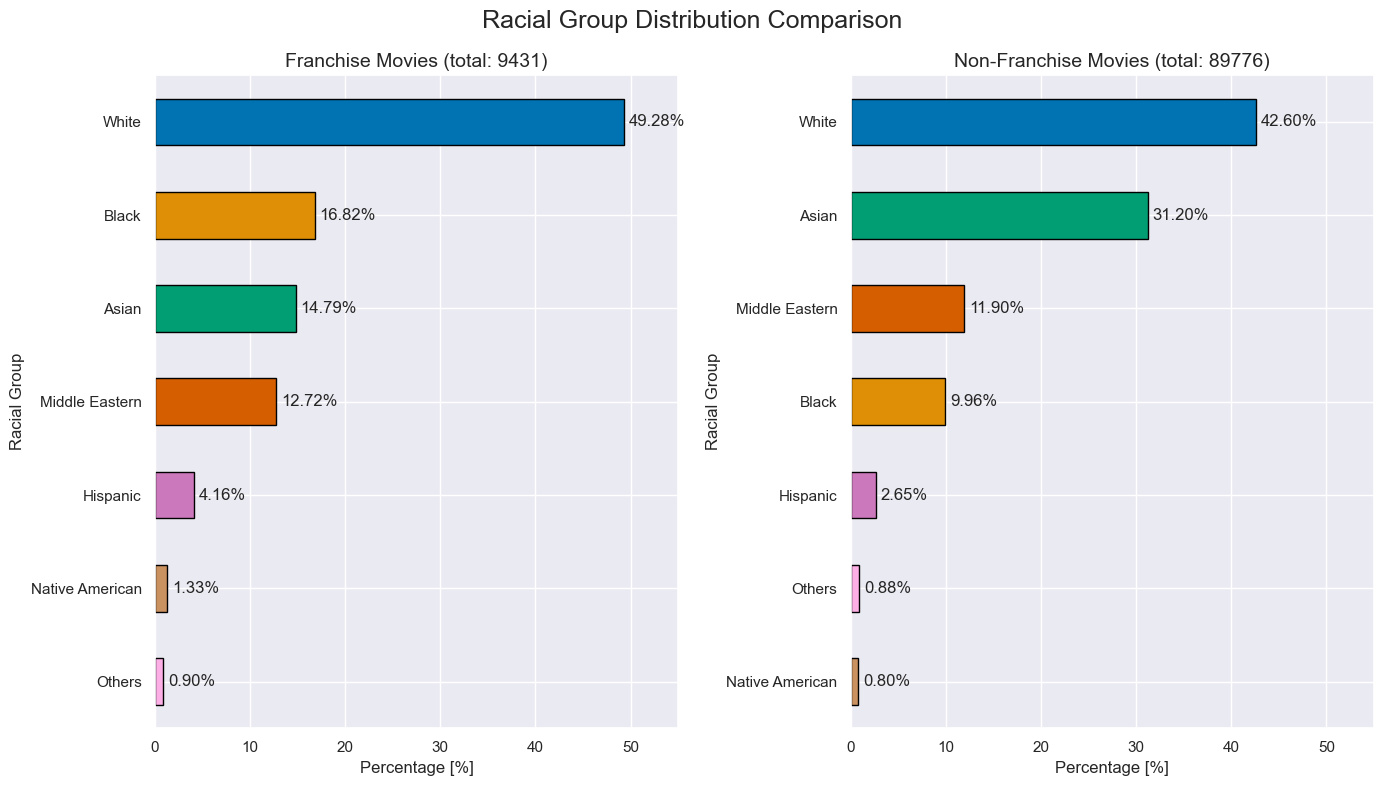

In [ ]:
# Define colors for racial groups
colors = dict(zip(['White', 'Black', 'Asian', 'Middle Eastern', 'Hispanic', 'Native American', 'Others'], sns.color_palette("colorblind", 7)))

# Calculate the percentage of each racial group for franchise and non-franchise movies
racial_proportion_franchise = character_df[character_df["is_in_franchise"]].value_counts("racial_group")
racial_proportion_non_franchise = character_df[~character_df['is_in_franchise']].value_counts("racial_group")
percentage_fr = (racial_proportion_franchise / racial_proportion_franchise.sum()) * 100
percentage_non_fr = (racial_proportion_non_franchise / racial_proportion_non_franchise.sum()) * 100
fr_count = racial_proportion_franchise.sum()
non_fr_count = racial_proportion_non_franchise.sum()

# Plot the racial percentages as horizontal bar charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot for franchise movies
bars_fr = percentage_fr.plot(kind='barh', ax=axes[0], color=[colors[group] for group in percentage_fr.index], edgecolor='black')
axes[0].set_title(f'Franchise Movies (total: {fr_count})', fontsize=14)
axes[0].set_xlabel('Percentage [%]')
axes[0].set_ylabel('Racial Group')
axes[0].invert_yaxis()  # Inverse y-axis
axes[0].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_fr.patches:
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

# Plot for non-franchise movies
bars_non_fr = percentage_non_fr.plot(kind='barh', ax=axes[1], color=[colors[group] for group in percentage_non_fr.index], edgecolor='black')
axes[1].set_title(f'Non-Franchise Movies (total: {non_fr_count})', fontsize=14)
axes[1].set_xlabel('Percentage [%]')
axes[1].set_ylabel('Racial Group')
axes[1].invert_yaxis()  # Inverse y-axis
axes[1].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_non_fr.patches:
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

# Set overarching title
fig.suptitle('Racial Group Distribution Comparison', fontsize=18)

plt.tight_layout()
plt.show()

Perhaps, fewer franchise in asia?

In [ ]:
def create_from_asia(df):
    asian_countries = [
    # Asia
    "AF", "BD", "BT", "BN", "KH", "CN", "TL", "IN", "ID", "JP", 
    "KZ", "KG", "LA", "MY", "MV", "MN", "MM", "NP", "PK", "PH", 
    "SG", "KR", "LK", "TJ", "TH", "TM", "UZ", "VN", "KP",
    
    # Russia
    "RU",
    
    # Oceania
    "AS", "AU", "CK", "FJ", "FM", "GU", "KI", "MH", "NR", "NC", 
    "NZ", "NU", "PW", "PG", "PN", "SB", "TK", "TO", "TV", "VU", "WF", "WS"
]


    list_of_countries = df.tmdb_origin_country.fillna('')
    for i in range(len(list_of_countries)):
        list_of_countries.iloc[i] = list_of_countries.iloc[i].strip("[]").replace("'", "").split(", ")

    # check if asia is in the list of countries
    assert len(df) == len(list_of_countries), "Length of dataframe and list of countries do not match"
    bool_list = []
    for l in list_of_countries:
        if any([country in asian_countries for country in l]):
            bool_list.append(True)
        else:
            bool_list.append(False)
    df["is_from_asia"] = bool_list
    return df

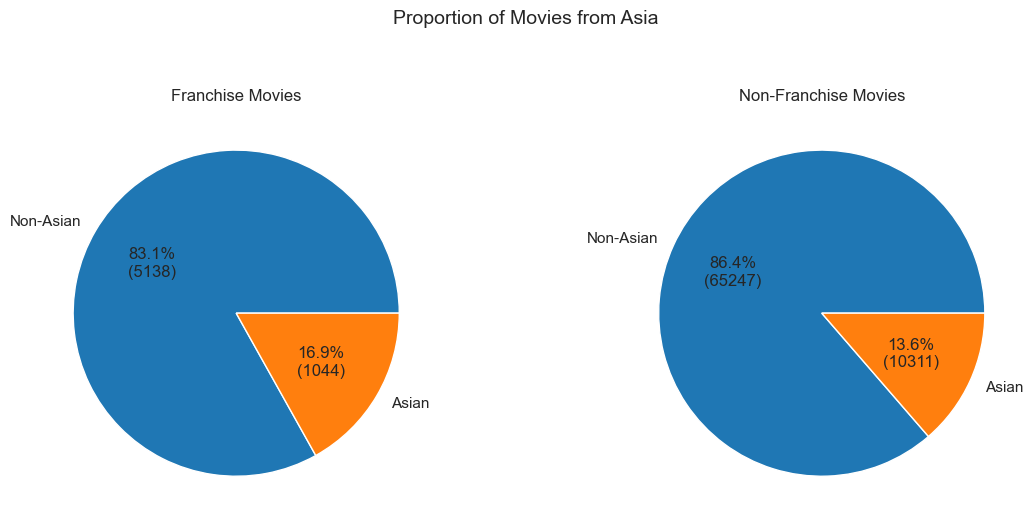

In [ ]:
# Calculate proportions for both franchise and non-franchise movies
asia_prop_fr = movies_df[movies_df['collection_id'].notna()]['is_from_asia'].value_counts()
asia_prop_non_fr = movies_df[movies_df['collection_id'].isna()]['is_from_asia'].value_counts()

# Create side-by-side pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot franchise movies
asia_prop_fr.plot(kind='pie', ax=ax1, autopct=custom_autopct(asia_prop_fr), 
                 labels=['Non-Asian', 'Asian'], colors=['#1f77b4', '#ff7f0e'])
ax1.set_title('Franchise Movies')
ax1.set_ylabel('')

# Plot non-franchise movies  
asia_prop_non_fr.plot(kind='pie', ax=ax2, autopct=custom_autopct(asia_prop_non_fr),
                     labels=['Non-Asian', 'Asian'], colors=['#1f77b4', '#ff7f0e'])
ax2.set_title('Non-Franchise Movies')
ax2.set_ylabel('')

plt.suptitle('Proportion of Movies from Asia', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()